# Dwell time analysis

- [Maximum likelihood estimation](maximum_likelihood_estimation)
- [Histogram fit](histogram_fit)
- [Cumulative density function fit](cdf_fit)

In [1]:
from pathlib import Path
import sys
papylio_path = Path.cwd()
for i in range(20):
    papylio_path = papylio_path.parent
    if papylio_path.name == 'papylio':
        break
        
sys.path.append(str(papylio_path))
import papylio as pp

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

experiment_path = papylio_path / 'tests' / 'integration' / 'data' / 'Papylio example dataset - analyzed'
experiment_path

exp = pp.Experiment(experiment_path)
file = exp.files.select('HJ', 'name')[0]
files = exp.files.select('HJ1', 'name')

Import files: 100%|██████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 2196.03it/s]



Initialize experiment: 
C:\Users\user\surfdrive\Promotie\Code\Python\papylio\tests\integration\data\Papylio example dataset - analyzed


## Dwell time extraction
Dwell times can be extracted from the overall classification `File.classification` using the `File.determine_dwells_from_classification` method:.

In [2]:
file.determine_dwells_from_classification(variable='FRET', selected=True, inactivate_start_and_end_states=True)

The method will create an additional .nc file named ``<filename>_dwells.nc``.

The contents from this file can be obtained using:

In [3]:
file.dwells

<xarray.Dataset>
Dimensions:           (dwell: 43360)
Dimensions without coordinates: dwell
Data variables:
    molecule_in_file  (dwell) int32 0 0 0 0 0 0 0 ... 821 823 824 824 825 825
    file              (dwell) |S25 b'ssHJ1\\ssHJ1 TIRF 561 0001' ... b'ssHJ1\...
    molecule          (dwell) int64 0 0 0 0 0 0 0 ... 821 823 824 824 825 825
    state             (dwell) int8 -128 1 0 1 0 1 ... -128 -128 -128 -1 -128 -1
    frame_count       (dwell) int64 2 1 4 2 1 2 1 1 ... 4 2 8 400 354 46 167 233
    duration          (dwell) float64 0.245 0.1225 0.4899 ... 5.634 20.45 28.54
    mean_FRET         (dwell) float64 0.2086 0.3119 0.2062 ... 0.00134 0.03914
    number_of_states  (dwell) int32 2 2 2 2 2 2 2 2 2 2 ... 2 2 2 2 2 1 1 1 1 1
Attributes:
    selected:  True

For each dwell the following information is provided:

* ``file``:  the file from which it originates
* ``molecule_in_file``: the molecule index in the original file
* ``state``: the state of the dwell
* ``frame_count``: the dwell duration in frames
* ``duration``: the dwell duration in time
* ``mean_<variable_name>``: the mean of the used variable

The dwells with positive states that are at the beginning or the end of a trace, or have a negative state neighbor, are inactivated (i.e. set to state ``-128``) by default. This is done because the events are interrupted and the full dwell time cannot be observed. In case this is not desired, the `inactivate_start_and_end_states` argument can be set to `False`. 


## Dwell time analysis

The dwell times can be analyzed from a file object using the `File.analyze_dwells` method. This produces a fit result in the form of an xarray Dataset, containing the fit values for each state, each fit and each component.

In [4]:
_ = file.analyze_dwells(method='histogram_fit', number_of_exponentials=[1,2])

The dwell times are used to estimate the parameters of a single or multi-component exponential distribution

$$
\text{PDF} = \sum_{i=1}^n P_i k_i e^{k_i t}
$$

where $\text{PDF}$ is the probability density function over time $t$ and $P_i$ is the fractional contribution and $k$ the reaction rate of the $i$-th component out of a total of $n$ components.

The number of components can be indicated through the `number_of_exponentials` argument.

There are three analysis methods available:
- [Maximum likelihood estimation](maximum_likelihood_estimation.ipynb)
- [Histogram fit](histogram_fit.ipynb)
- [Cumulative density function (CDF) fit](cdf_fit.ipynb)

The analysis result is automatically saved in an `<filename>_dwell_analysis.nc` netcdf file and can be accessed through:

In [5]:
file.dwell_analysis

<xarray.Dataset>
Dimensions:               (state: 2, component: 2, fit: 2)
Coordinates:
  * state                 (state) int64 0 1
  * component             (component) int32 0 1
Dimensions without coordinates: fit
Data variables:
    P                     (state, fit, component) float64 1.0 nan ... 0.4664
    k                     (state, fit, component) float64 2.487 nan ... 5.969
    truncation_min        (state, fit) float64 0.05803 0.06927 0.06052 0.06052
    P_error               (state, fit, component) float64 nan nan ... nan
    k_error               (state, fit, component) float64 1.604 nan ... 7.33e+05
    truncation_min_error  (state, fit) float64 0.1791 0.2913 0.04902 0.05991
    BIC                   (state, fit) float64 9.48e+04 9.438e+04 ... 5.865e+04
    number_of_components  (state, fit) int32 1 2 1 2
Attributes:
    papylio_version:                 0.0.0
    fit_function:                    exponential
    P_bounds:                        [-1  1]
    k_bounds:                        [1.e-09    inf]
    fit_method:                      histogram_fit
    bins:                            auto_discrete
    remove_first_bins:               0
    scipy_curve_fit_absolute_sigma:  True
    sampling_interval:               0.12248370927318296

The fit result can be plotted using `File.plot_dwell_analysis`:

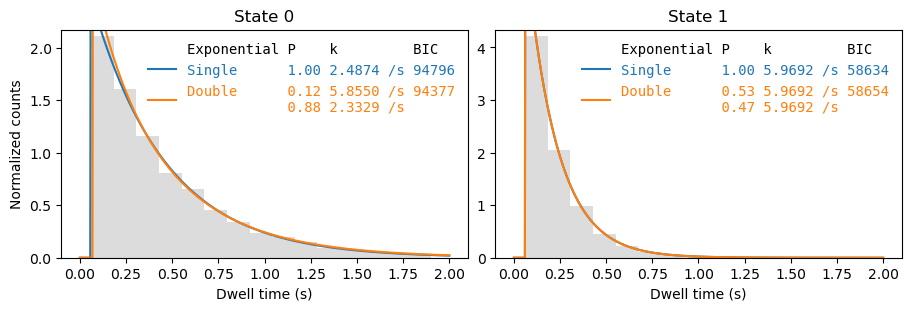

In [6]:
fig, axes = plt.subplots(1,2, figsize=(9,3), layout='constrained')
_  = file.plot_dwell_analysis(plot_range=(0,2), axes=axes, log=False)

C:\Users\user\surfdrive\Promotie\Code\Python\papylio\papylio\analysis\dwell_time_analysis.py:840: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0,counts.max()*1.03)
C:\Users\user\surfdrive\Promotie\Code\Python\papylio\papylio\analysis\dwell_time_analysis.py:840: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0,counts.max()*1.03)


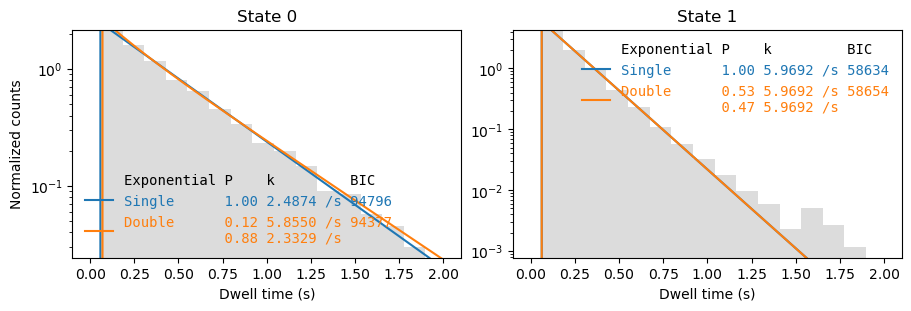

In [7]:
fig, axes = plt.subplots(1,2, figsize=(9,3), layout='constrained')
_  = file.plot_dwell_analysis(plot_range=(0,2), axes=axes, log=True)

### Combining data from multiple files

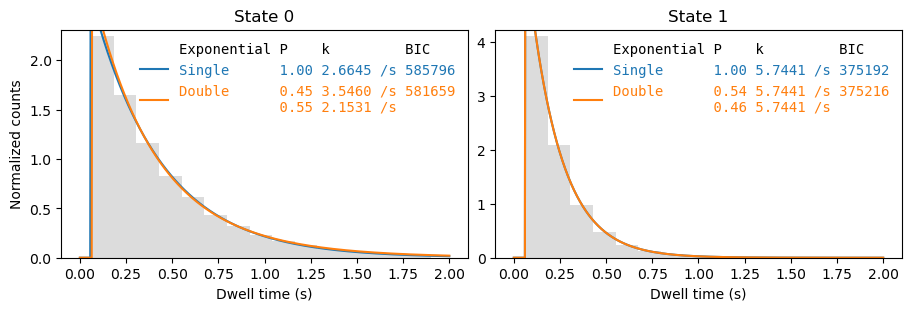

In [8]:
from papylio.analysis.dwell_time_analysis import analyze_dwells, plot_dwell_analysis

dwells = files.dwells
dwell_analysis = analyze_dwells(dwells, method='histogram_fit', number_of_exponentials=[1,2])

fig, axes = plt.subplots(1,2, figsize=(9,3), layout='constrained')
_ = plot_dwell_analysis(dwell_analysis, dwells, plot_type='pdf', plot_range=(0,2), axes=axes)